In [14]:
# import packages
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['figure.figsize'] = [11, 4]


In [2]:
def basic_plot(df, x_axis, y_axis, title):
    df.plot()
    plt.xlabel(x_axis)
    plt.ylabel(y_axis)
    plt.title(title)
    plt.legend()

In [3]:
# set filepaths (3 files)
isr_csv1 = '../data/ISR/01-JAN-2016 to 28-FEB-2017 - ISR - JUV Redacted.csv'
isr_csv2 = '../data/ISR/29-FEB-2016 thru 16-JAN-2018 - ISR - JUV Redacted.csv'
isr_csv3 = '../data/ISR/ISR-1-Jan-2018--31-Dec-2019-Juv-Redacted.csv'
csv_list = [isr_csv1, isr_csv2, isr_csv3]

In [4]:
# Load all files and concatenate into one
isr_dfs = []
for csv in csv_list:
    new_df = pd.read_csv(csv, low_memory=False)
    isr_dfs.append(new_df)
isr_raw_df = pd.concat(isr_dfs)

In [5]:
# Keep raw version
isr_raw_df.shape

(647021, 171)

In [16]:
# Remove redacted juvenile records
isr_df = isr_raw_df[isr_raw_df['CONTACT_DATE']!='REDACTED']
# Drop duplicates (Appear to be overlapping dates)
isr_df = isr_df.drop_duplicates()

In [17]:
isr_df.shape

(505579, 171)

In [18]:
isr_df['DATETIME'] = pd.to_datetime(isr_df['CONTACT_DATE'])

In [19]:
isr_df['DATETIME'].min()

Timestamp('2016-01-01 00:02:00')

In [20]:
isr_df['DATETIME'].max()

Timestamp('2019-12-31 23:55:00')

In [22]:
isr_df['DATE'] = isr_df['DATETIME'].dt.date

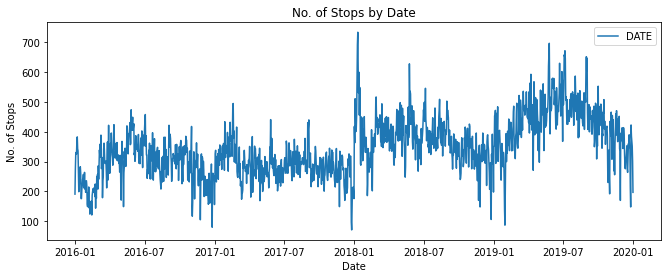

In [23]:
basic_plot(isr_df['DATE'].value_counts(), 'Date', 'No. of Stops', 'No. of Stops by Date')

We may need to look at dropping duplicates based on each CARD_NO. Each ISR is identified by a unique CARD_NO, but there may be revised records.  As a first step, let's use the most recent revision for a given CARD_NO.

In [26]:
# How many card numbers have multiple records?
sum(isr_df['CARD_NO'].value_counts()>1)

26147

In [27]:
isr_df['CARD_NO'].value_counts()

ISR000201007    8
ISR000198068    8
ISR000050767    8
ISR000153909    8
ISR000102091    8
               ..
ISR000502272    1
ISR000528232    1
ISR000975066    1
ISR002830000    1
ISR001855247    1
Name: CARD_NO, Length: 475184, dtype: int64

In [31]:
isr_df[isr_df['CARD_NO']=='ISR000201007'][['MODIFIED_DATE', 'ENFORCEMENT_TYPE_CD']]

,MODIFIED_DATE,ENFORCEMENT_TYPE_CD
25994,2/13/2017 5:10,NaN
25995,3/1/2017 1:45,NaN
25997,2/28/2017 18:07,NaN
25998,2/13/2017 20:52,NaN
94593,3/1/2017 1:45,NaN
94594,2/28/2017 18:07,NaN
94595,2/13/2017 5:10,NaN
94597,2/13/2017 20:52,NaN


In [32]:
test_df = isr_df[isr_df['CARD_NO']=='ISR000201007']

In [33]:
for col in test_df.columns:
    print(col, test_df.duplicated(subset=col).sum())

CONTACT_CARD_ID 4
CONTACT_TYPE_CD 7
CARD_NO 7
CONTACT_DATE 7
CONTACT_HOUR 7
SUBMITTING_BEAT_CD 7
JUVENILE_I 7
CLOTHING_DESCR 7
NAME_VERIFIED_I 6
RD_NO 6
HOTSPOT_NO 7
EVENT_NO 7
MISSION_NO 7
CPD_UNIT_NO 7
CREATED_BY 7
CREATED_DATE 7
MODIFIED_BY 7
MODIFIED_DATE 4
AGE 7
AGE_TO 7
SEX_CODE_CD 7
RACE_CODE_CD 7
HEIGHT 7
WEIGHT 7
BUILD_CODE_CD 7
EYE_COLOR_CODE_CD 7
HAIR_COLOR_CODE_CD 7
HAIR_STYLE_CODE_CD 7
COMPLEXION_CODE_CD 7
STREET_NO 7
STREET_DIRECTION_CD 7
STREET_NME 7
APT_NO 7
CITY 7
STATE_CD 7
ZIP_CD 7
HALF_ADDRESS_I 6
DISTRICT 7
SECTOR 7
BEAT 7
AREA 7
WARD 7
RES_DISTRICT 7
RES_SECTOR 7
RES_BEAT 7
RES_AREA 7
RES_WARD 7
BUS_DISTRICT 7
BUS_SECTOR 7
BUS_BEAT 7
BUS_AREA 7
BUS_WARD 7
SUBMITTING_UNIT 7
CONTACT_TYPE_DESCR 7
V_YEAR 7
MAKE_CD 7
MAKE_DESCR 7
STYLE_CD 7
STYLE_DESCR 7
TYPE_CD 7
MODEL_DESCR 7
COLOR_TOP 7
COLOR_BOTTOM 7
FO_EMPLOYEE_ID 7
SO_EMPLOYEE_ID 7
SUPV_EMPLOYEE_ID 6
GANG 7
KNOWN_HANGOUT 7
FACTION_NAME 7
CONTACT_CARD_STATUS_CD 6
COMPLETION_I 7
LOCATION_CD 7
HANDCUFFED_I 7
VEHICLE

In [34]:
isr_df['MODIFIED_DATETIME'] = pd.to_datetime(isr_df['MODIFIED_DATE'])

In [36]:
# Sort by date of record modification (descending)
isr_df = isr_df.sort_values(by='MODIFIED_DATETIME', ascending=False)

In [37]:
# Check for one example
isr_df[isr_df['CARD_NO']=='ISR000201007'][['CARD_NO', 'MODIFIED_DATETIME']]

,CARD_NO,MODIFIED_DATETIME
94593,ISR000201007,2017-03-01 01:45:00
25995,ISR000201007,2017-03-01 01:45:00
25997,ISR000201007,2017-02-28 18:07:00
94594,ISR000201007,2017-02-28 18:07:00
94597,ISR000201007,2017-02-13 20:52:00
25998,ISR000201007,2017-02-13 20:52:00
25994,ISR000201007,2017-02-13 05:10:00
94595,ISR000201007,2017-02-13 05:10:00


In [38]:
# Keep only most recent record per card number
isr_df = isr_df.drop_duplicates(subset = 'CARD_NO')

In [39]:
# Check the previous example card no.
isr_df[isr_df['CARD_NO']=='ISR000201007'][['CARD_NO', 'MODIFIED_DATETIME']]

,CARD_NO,MODIFIED_DATETIME
94593,ISR000201007,2017-03-01 01:45:00


In [40]:
isr_df.shape

(475184, 174)

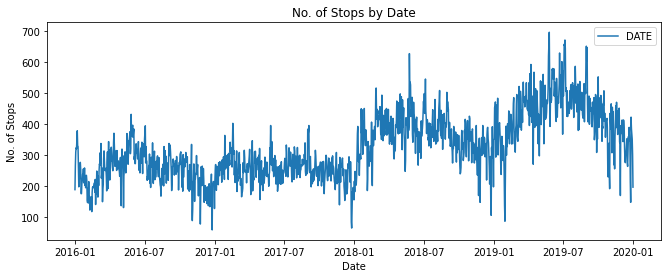

In [41]:
basic_plot(isr_df['DATE'].value_counts(), 'Date', 'No. of Stops', 'No. of Stops by Date')

Success - we've removed some of the weird spikes in the data!

In [44]:
isr_df['CONTACT_TYPE_CD'].value_counts()

INVSTG     452862
GANGLTR     22321
Name: CONTACT_TYPE_CD, dtype: int64

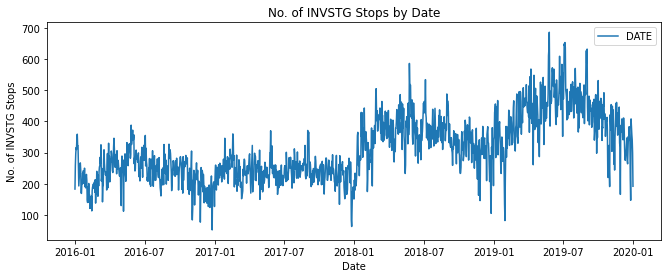

In [46]:
stop_type = 'INVSTG'
basic_plot(isr_df[isr_df['CONTACT_TYPE_CD']==stop_type]['DATE'].value_counts(), 
               'Date', f'No. of {stop_type} Stops', f'No. of {stop_type} Stops by Date')


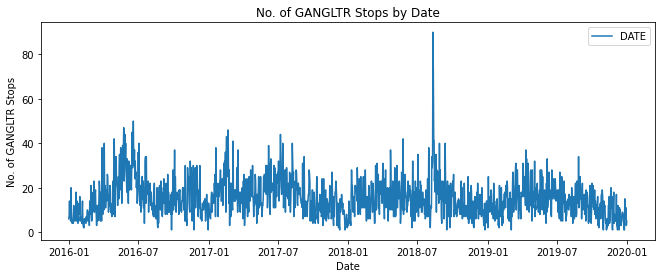

In [47]:
stop_type = 'GANGLTR'
basic_plot(isr_df[isr_df['CONTACT_TYPE_CD']==stop_type]['DATE'].value_counts(), 
               'Date', f'No. of {stop_type} Stops', f'No. of {stop_type} Stops by Date')


In [50]:
isr_df['VEHICLE_INVOLVED_I'].value_counts()

N    304888
Y    170296
Name: VEHICLE_INVOLVED_I, dtype: int64

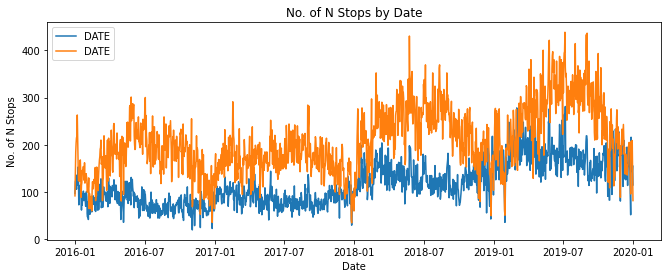

In [54]:
for stop_type in ['Y', 'N']:
    basic_plot(isr_df[isr_df['VEHICLE_INVOLVED_I']==stop_type]['DATE'].value_counts(), 
               'Date', f'No. of {stop_type} Stops', f'No. of {stop_type} Stops by Date')